In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

In [2]:
PATH = '/content/drive/MyDrive/github/studying/cv-age-recognition/faces/'

In [3]:
labels_train = pd.read_csv(PATH + 'labels_train.csv')
labels_valid = pd.read_csv(PATH + 'labels_valid.csv')
labels_test = pd.read_csv(PATH + 'labels_test.csv')

In [4]:
datagen = ImageDataGenerator(rescale=1/255.0)

In [5]:
test_datagen = datagen.flow_from_dataframe(dataframe=labels_test,
                                           directory=PATH + 'test',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224,224),
                                           batch_size=16,
                                           class_mode='raw',
                                           seed=12345)
features_test, target_test = next(test_datagen)

Found 1978 validated image filenames.


In [6]:
valid_datagen = datagen.flow_from_dataframe(dataframe=labels_valid,
                                            directory=PATH + 'valid',
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='raw',
                                            seed=12345)

Found 1500 validated image filenames.


In [7]:
train_datagen = datagen.flow_from_dataframe(dataframe=labels_train,
                                            directory=PATH + 'train',
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='raw',
                                            seed=12345)

Found 4113 validated image filenames.


In [8]:
labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  4113 non-null   object
 1   real_age   4113 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


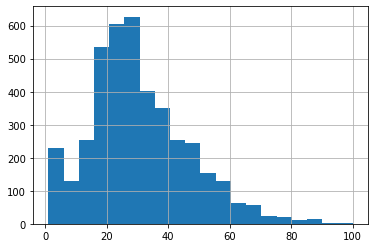

In [9]:
labels_train['real_age'].hist(bins=20)

Средний возраст в районе 30 лет

In [10]:
features_train, target_train = next(train_datagen)

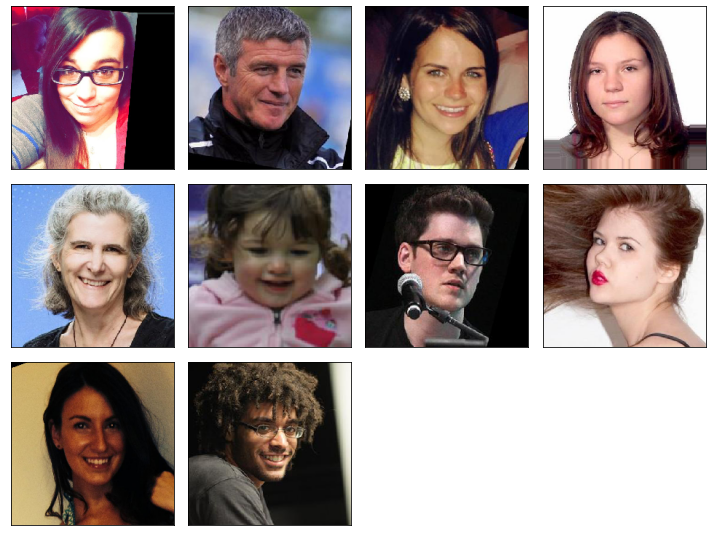

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Пример фотографий

In [12]:
labels_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1500 non-null   object
 1   real_age   1500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.6+ KB


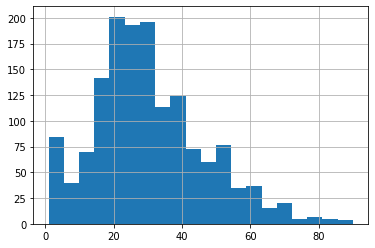

In [13]:
labels_valid['real_age'].hist(bins=20)

In [14]:
features_valid, target_valid = next(valid_datagen)

In [15]:
layer = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)
model = Sequential()
model.add(layer)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu')) 
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

In [16]:
model.fit(train_datagen,
          validation_data=valid_datagen,
          epochs=10,
          verbose=1,
          shuffle=True,
          batch_size=16)

Epoch 1/10
258/258 [==============================] - 49s 167ms/step - loss: 378.0066 - mae: 14.3888 - val_loss: 903.0375 - val_mae: 25.5238
Epoch 2/10
258/258 [==============================] - 42s 161ms/step - loss: 72.2733 - mae: 6.5050 - val_loss: 249.0582 - val_mae: 12.2981
Epoch 3/10
258/258 [==============================] - 42s 162ms/step - loss: 41.3642 - mae: 4.9423 - val_loss: 126.6224 - val_mae: 8.4057
Epoch 4/10
258/258 [==============================] - 41s 160ms/step - loss: 29.0410 - mae: 4.0891 - val_loss: 103.2602 - val_mae: 7.7702
Epoch 5/10
258/258 [==============================] - 41s 161ms/step - loss: 23.9512 - mae: 3.7552 - val_loss: 81.6985 - val_mae: 6.5978
Epoch 6/10
258/258 [==============================] - 42s 161ms/step - loss: 19.1305 - mae: 3.3849 - val_loss: 90.0092 - val_mae: 7.2649
Epoch 7/10
258/258 [==============================] - 42s 161ms/step - loss: 17.6404 - mae: 3.2179 - val_loss: 88.5960 - val_mae: 6.6851
Epoch 8/10
258/258 [=============

In [17]:
predictions = model.predict(features_test, batch_size=16, verbose=1)

1/1 [==============================] - 1s 731ms/step


In [18]:
mean_absolute_error(target_test, predictions)

6.083438947796822